Execute only on Google Colab


In [2]:
!pip install tonic
!pip install sinabs
!pip install torchmetrics
!pip install numpy --upgrade


  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.3.2
    Uninstalling numpy-2.3.2:
      Successfully uninstalled numpy-2.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible

  Using cached numpy-2.3.2-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)
Using cached numpy-2.3.2-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (16.6 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tonic 1.6.0 requires numpy<2.0.0, but you have numpy 2.3.2 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.2 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.2 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.2 which is incompatible.
numba 0

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torchmetrics
import os
import sinabs
import sinabs.layers as sl
from tqdm import tqdm

from sinabs.hooks import register_synops_hooks

/Users/benedettoleto/PycharmProjects/inNuCE_BRANDY-2025/.conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Apple Silicon GPU)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA GPU")
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")
    print("Using CPU")

Using MPS (Apple Silicon GPU)


In [3]:
def create_model(batch_size):
    """Create the SNN model"""
    backend = sl
    min_v_mem = -1.

    model = nn.Sequential(
        sl.FlattenTime(),
        nn.Conv2d(2, 8, kernel_size=3, padding=1, bias=False),
        backend.IAFSqueeze(batch_size=batch_size, min_v_mem=min_v_mem),
        sl.SumPool2d(2),
        nn.Conv2d(8, 16, kernel_size=3, padding=1, bias=False),
        backend.IAFSqueeze(batch_size=batch_size, min_v_mem=min_v_mem),
        sl.SumPool2d(2),
        nn.Conv2d(16, 32, kernel_size=3, padding=1, bias=False),
        backend.IAFSqueeze(batch_size=batch_size, min_v_mem=min_v_mem),
        sl.SumPool2d(2),
        nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False),
        backend.IAFSqueeze(batch_size=batch_size, min_v_mem=min_v_mem),
        sl.SumPool2d(2),
        nn.Conv2d(64, 10, kernel_size=2, padding=0, bias=False),
        backend.IAFSqueeze(batch_size=batch_size, min_v_mem=min_v_mem),
        nn.Flatten(),
        sl.UnflattenTime(batch_size=batch_size),
    )
    return model


Bias are set to False to avoid chip running at fixed frequency: https://sinabs.readthedocs.io/v3.0.3/speck/notebooks/leak_neuron.html

# DataLoading

Load NeuromorphicMNIST dataset.

In [4]:
from tonic import datasets, transforms

def get_data_loaders(batch_size):
    """Create data loaders"""
    transform = transforms.Compose([
        transforms.ToFrame(sensor_size=(34, 34, 2), n_time_bins=30, include_incomplete=True),
        lambda x: torch.from_numpy(x.astype(np.float32)),
    ])

    trainset = datasets.NMNIST('./data', train=True, transform=transform)
    testset = datasets.NMNIST('./data', train=False, transform=transform)

    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers=0,
        drop_last=True, pin_memory=True
    )
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, num_workers=0,
        drop_last=True, pin_memory=True
    )

    return trainloader, testloader

In [5]:
def evaluate_model(model, testloader, device):
    """Evaluate model on test set"""
    acc = torchmetrics.Accuracy('multiclass', num_classes=10).to(device)
    model.eval()

    total_loss = 0
    num_batches = 0

    with torch.no_grad():
        for data, targets in tqdm(testloader, desc="Evaluating"):
            data, targets = data.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            sinabs.reset_states(model)

            y_hat = model(data)
            pred = y_hat.sum(1)
            loss = nn.functional.cross_entropy(pred, targets)

            acc(pred, targets)
            total_loss += loss.item()
            num_batches += 1

    accuracy = acc.compute().item()
    avg_loss = total_loss / num_batches

    return accuracy, avg_loss

In [29]:
def train_and_evaluate(lr, batch_size, epochs, target_synops):
    """Main training and evaluation function for wandb sweep"""

    learning_rate = lr
    batch_size = batch_size
    n_epochs = epochs

    acc = torchmetrics.Accuracy('multiclass', num_classes=10).to(device)

    # Create model and move to device
    model = create_model(batch_size)
    model = model.to(device)

    if target_synops:
        # Register synops hooks
        register_synops_hooks(model)


    # Create data loaders
    trainloader, testloader = get_data_loaders(batch_size)

    # Create optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(n_epochs):
        model.train()

        pbar = tqdm(trainloader, desc=f'Epoch {epoch+1}/{n_epochs}')
        sinabs.reset_states(model)
        sinabs.zero_grad(model)
        optimizer.zero_grad()

        for data, targets in pbar:
            sinabs.reset_states(model)
            optimizer.zero_grad()

            data, targets = data.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            output = model(data).sum(1)

            target_loss = nn.functional.cross_entropy(output, targets)
            if target_synops:
                synops = model.hook_data['total_synops_per_timestep'].item()
                synops_loss = ((synops - target_synops) / target_synops) ** 2
                loss = target_loss + synops_loss
            else:
                loss = target_loss

            accuracy = acc(output, targets)
            loss.backward()
            optimizer.step()

            current_loss = loss.item()

            # Update progress bar
            pbar.set_postfix({
                'train_loss': f'{current_loss:.4f}',
                'train_acc': f'{accuracy.item():.2%}',
            })

        # Evaluate on test set
        test_acc, test_loss = evaluate_model(model, testloader, device)

        pbar.set_postfix({
            'train_loss': f'{current_loss:.4f}',
            'train_acc': f'{accuracy:.2%}',
            'test_loss': f'{test_loss:.4f}',
            'test_acc': f'{test_acc:.4f}',
            
        })



    # Final evaluation
    final_accuracy, final_loss = evaluate_model(model, testloader, device)


    print("\nTraining complete.")
    print(f"Final accuracy: {final_accuracy:.2%}")
    print(f"Final loss: {final_loss:.4f}")

    os.makedirs('saved_models', exist_ok=True)
    torch.save(model.cpu(), 'saved_models/'+f"{final_accuracy:.4f}.pth")

### Train with no synops regulation

In [16]:
lr = 1e-3
batch_size = 32
epochs = 2
train_and_evaluate(lr, batch_size, epochs, target_synops=False)

Evaluating: 100%|██████████| 312/312 [00:10<00:00, 29.32it/s]


Training complete.
Final accuracy: 97.85%
Final loss: 0.0704


In [19]:
lr = 1e-3
batch_size = 32
epochs = 2
target_synops = 12000
train_and_evaluate(lr, batch_size, epochs, target_synops=target_synops)

Evaluating: 100%|██████████| 312/312 [00:10<00:00, 28.59it/s]


Training complete.
Final accuracy: 97.27%
Final loss: 0.0834


In [30]:
lr = 1e-3
batch_size = 32
epochs = 2
target_synops = 5000
train_and_evaluate(lr, batch_size, epochs, target_synops=target_synops)

Evaluating: 100%|██████████| 312/312 [00:11<00:00, 27.74it/s]


Training complete.
Final accuracy: 97.66%
Final loss: 0.0711


In [31]:
import sinabs.layers as sl

from sinabs.hooks import register_synops_hooks, firing_rate_hook, get_hook_data_dict

def record_output_hook(module, input, output):
    data = get_hook_data_dict(module)
    data["output"] = output

def register_hooks(model):
    register_synops_hooks(model)
    for layer in model:
        if isinstance(layer, sl.StatefulLayer) and layer.does_spike:
            layer.register_forward_hook(firing_rate_hook)
            layer.register_forward_hook(record_output_hook)

def sinabs_total_syn_ops(model):
    # NOTE: This is averaged across the batch and timesteps
    return model.hook_data['total_synops_per_timestep'].item()

def sinabs_syn_ops_by_layer(model):
    # NOTE: This is averaged across the batch and timesteps
    counts = [x.item() for x in model.hook_data['synops_per_timestep'].values()]
    return counts

def sinabs_firing_rate_by_layer(model):
    # NOTE: This is per neuron averaged across the batch and timesteps
    rates = []
    for layer in model:
        if isinstance(layer, sl.StatefulLayer) and layer.does_spike:
            rates.append(layer.hook_data['firing_rate'].item())

    return rates

def activation_sparsity(model):
    total_spike_num = 0  # Count of non-zero activations
    total_neuro_num = 0  # Count of all activations

    sparsity_by_layer = []

    for layer in model:
            if isinstance(layer, sl.StatefulLayer) and layer.does_spike:
                total_spike_num += layer.hook_data['output'].gt(0).sum().item()
                total_neuro_num += layer.hook_data['output'].numel()

                sparsity_by_layer.append((layer.hook_data['output'].numel() - layer.hook_data['output'].gt(0).sum().item())/layer.hook_data['output'].numel())

    sparsity = (total_neuro_num - total_spike_num) / total_neuro_num
    return sparsity, sparsity_by_layer

In [32]:
trainloader, testloader = get_data_loaders(32)
loader_data = next(iter(trainloader))

/Users/benedettoleto/PycharmProjects/inNuCE_BRANDY-2025/.conda/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [33]:
data = loader_data[0]

results_list = []

for path in os.listdir("./saved_models/"):
  if not path.endswith(".pth"):
      continue
  
  model = torch.load("./saved_models/"+path, weights_only=False)
  register_hooks(model)
  sinabs.reset_states(model)
  model(data)
  tot_syn_ops = sinabs_total_syn_ops(model) 
  synops_by_layer = sinabs_syn_ops_by_layer(model) 
  firing_rate_by_layer = sinabs_firing_rate_by_layer(model)
  tot_act_sparsity, act_sparsity_by_layer = activation_sparsity(model)
  results_list.append((path, tot_syn_ops, synops_by_layer, firing_rate_by_layer, tot_act_sparsity, act_sparsity_by_layer))

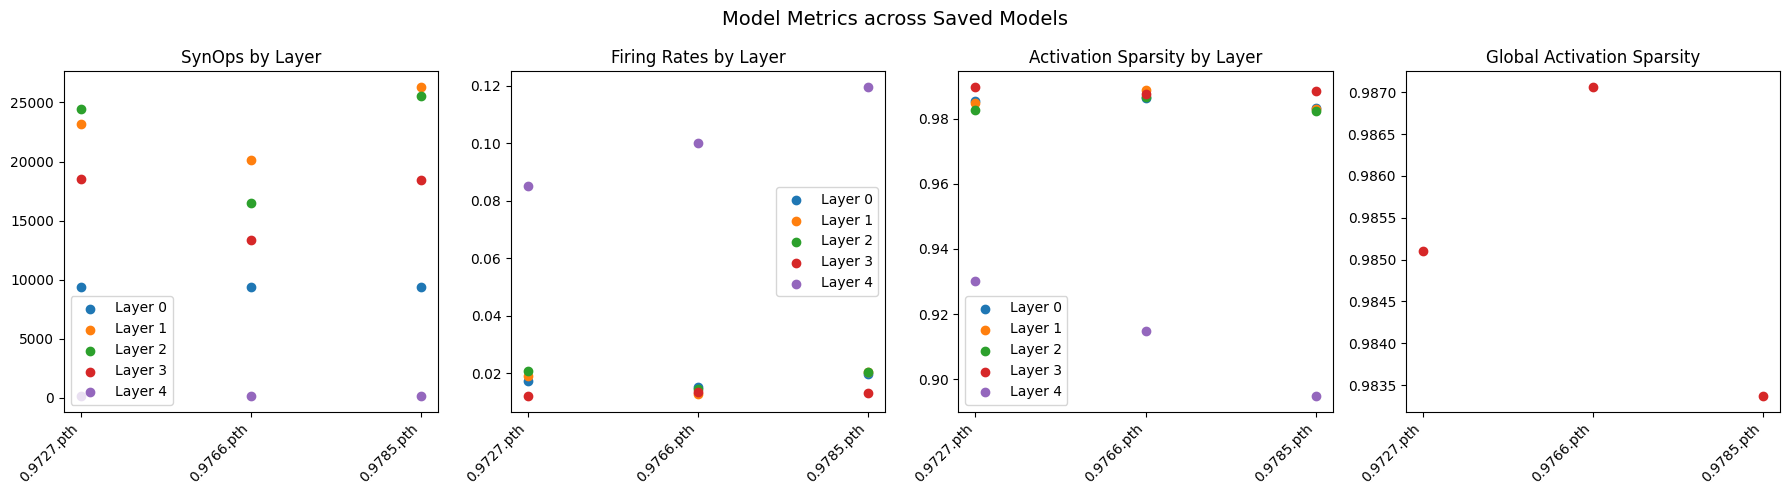

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert to DataFrame
df = pd.DataFrame(results_list, columns=[
    "model", "total_synops", "synops", "fire_rate", "act_sparsity", "act_sparsity_by_layer"
])

# Sort by model name (optional)
df.sort_values("model", inplace=True)

# Plot
fig, axs = plt.subplots(1, 4, figsize=(18, 5))
fig.suptitle("Model Metrics across Saved Models", fontsize=14)

x_positions = np.arange(len(df["model"]))  # numeric positions for scatter
x_labels = df["model"]

# Scatter SynOps by Layer
for i, layer in enumerate(np.stack(df['synops'].to_numpy()).T):
    axs[0].scatter(x_positions, layer, label=f"Layer {i}")
axs[0].set_title("SynOps by Layer")
axs[0].set_xticks(x_positions)
axs[0].set_xticklabels(x_labels, rotation=45, ha='right')
axs[0].legend()

# Scatter Firing Rate by Layer
for i, layer in enumerate(np.stack(df['fire_rate'].to_numpy()).T):
    axs[1].scatter(x_positions, layer, label=f"Layer {i}")
axs[1].set_title("Firing Rates by Layer")
axs[1].set_xticks(x_positions)
axs[1].set_xticklabels(x_labels, rotation=45, ha='right')
axs[1].legend()

# Scatter Activation Sparsity by Layer
for i, layer in enumerate(np.stack(df['act_sparsity_by_layer'].to_numpy()).T):
    axs[2].scatter(x_positions, layer, label=f"Layer {i}")
axs[2].set_title("Activation Sparsity by Layer")
axs[2].set_xticks(x_positions)
axs[2].set_xticklabels(x_labels, rotation=45, ha='right')
axs[2].legend()

# Scatter Global Activation Sparsity
axs[3].scatter(x_positions, df['act_sparsity'], color='tab:red')
axs[3].set_title("Global Activation Sparsity")
axs[3].set_xticks(x_positions)
axs[3].set_xticklabels(x_labels, rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [ ]:
import time
import torch
import numpy as np
import pandas as pd
from collections import defaultdict

import samna
from sinabs.backend.dynapcnn import DynapcnnNetwork
from sinabs.backend.dynapcnn.chip_factory import ChipFactory
from sinabs.backend.dynapcnn.dynapcnn_visualizer import DynapcnnVisualizer
from tonic import datasets, transforms
import os
import pandas as pd


transform = transforms.Compose([
        transforms.ToFrame(sensor_size=(34, 34, 2), n_time_bins=30, include_incomplete=True),
        lambda x: torch.from_numpy(x.astype(np.float32)),
    ])

def run_hw(model_path, monitor_layers='all'):

    testset = datasets.NMNIST('./data', train=False, transform=transform)
    class_samples = {i: [] for i in range(10)}  # Dictionary to store samples for each class
    
    for data, label in testset:
        if len(class_samples[label]) < 10:
            class_samples[label].append(data)
        if all(len(samples) == 10 for samples in class_samples.values()):
            break
    
    data = torch.stack([torch.stack(samples) for samples in class_samples.values()]).numpy()
    data = data.reshape(-1, 30, 2, 34, 34)  # Reshape to [batch_size, time_bins, channels, height, width]


    devices = samna.device.get_unopened_devices()
    speck = samna.device.open_device(devices[0])
    device_id = 'speck2fdevkit'

    try:

        cnn = torch.load(model_path, weights_only=False, map_location='cpu')

        print("Initialized SpeckModel.")

        data_shape = [100] + [30,2,34,34]
        
        print("Data prepared with shape: %s", data_shape)

        dynapcnn_model = DynapcnnNetwork(cnn[0:-1], input_shape=[2, 34, 34], dvs_input=False, discretize=True)
        print("Initialized DynapcnnNetwork.")
        dynapcnn_model.to(device_id, chip_layers_ordering="auto", monitor_layers='all', slow_clk_frequency=None)
        print("Model transferred to device.")
        layer_in = dynapcnn_model.chip_layers_ordering[0]


        chip_factory = ChipFactory(device_id)
        data = [chip_factory.raster_to_events(torch.from_numpy(x), layer=layer_in, dt=1/(data_shape[1]-1)) for x in data]
        print("Data converted to events.")

        pwr_mon = speck.get_power_monitor()
        source = pwr_mon.get_source_node()
        sink = samna.graph.sink_from(source)
        pwr_mon.start_auto_power_measurement(100.0)
        
        
        total_spike_num = 0
        total_neuro_num = 0
        layer_neuro_num = defaultdict(int)
        layer_spike_num = defaultdict(int)
        layer_sparsity = defaultdict(float)
        layer_outputs = defaultdict(list)

        start_ts = time.time()
        for sample in data:
            output_events = dynapcnn_model(sample)
            
            # #skip layers monitoring if not in config["monitor_layers"]
            if monitor_layers is None:
                continue
            
            for id, layer in enumerate(dynapcnn_model.chip_layers_ordering):

                output_events_layer = [each for each in output_events if each.layer == layer]

                if len(output_events_layer) == 0:
                    layer_neuro_num[id] += 0
                    layer_spike_num[id] += 0
                    continue
                layer_outputs[id].append(output_events_layer)

        end_ts = time.time()
        print(f"Processed all data samples in {end_ts - start_ts} seconds.")

        pwr_mon.stop_auto_power_measurement()
        powers = pd.DataFrame([(x.channel, x.value) for x in sink.get_events()], columns=["ch", "pwr"])

    finally:
    
        samna.device.close_device(speck)
        print("Closed device.")

        powers = powers.groupby('ch').mean()['pwr'].to_list()
        fps = len(data) / (end_ts - start_ts)
        print("FPS: %.2f", fps)

        dt= 1 / (data_shape[1] - 1)  

        for layer in layer_outputs.keys():
            for i in range(len(layer_outputs[layer])):
                layer_n_spks = chip_factory.events_to_raster(layer_outputs[layer][i], dt=dt)

                tot_neurons = layer_n_spks.numel()
                tot_spikes = layer_n_spks.gt(0.0).sum().item()

                layer_neuro_num[layer] += tot_neurons
                layer_spike_num[layer] += tot_spikes
                
                total_spike_num += tot_spikes
                total_neuro_num += tot_neurons


        for key in layer_neuro_num:
                sparsity = (
                    (layer_neuro_num[key] - layer_spike_num[key])
                    / layer_neuro_num[key]
                    if layer_neuro_num[key] != 0
                    else 0.0
                )
                layer_sparsity[key] = sparsity

        activation_sparsity = ((total_neuro_num - total_spike_num) / total_neuro_num) if total_neuro_num != 0 else 0.0

        print(f"Total spikes: {total_spike_num}")
        print(f"Total neurons: {total_neuro_num}")
        print(f"Tot. Dynamic Power: {(powers[1]+ powers[2])*1e3} mW")

        print(f"Activation sparsity: {activation_sparsity}")

        return powers, fps, activation_sparsity, dict(layer_sparsity), total_spike_num


if __name__ == "__main__":


    results = []

    # get all the model inside saved_models folder
    model_files = [f for f in os.listdir("./saved_models/") if f.endswith('.pth')]
    for model_file in model_files:
        model_path = os.path.join("./saved_models", model_file)
        
        print("Starting main execution.")
        print("Model name: %s", model_file)
        power, fps, act_sparsity, act_sp_by_layer, tot_spikes = run_hw(model_path)
        print("Results completed for model %s", model_file)
        results.append((model_file, power, fps, act_sparsity, act_sp_by_layer, tot_spikes))
        df = pd.DataFrame(results, columns=["model_name", "power", "fps", "act_sparsity", "act_sp_by_layer", "tot_spikes"])


Starting main execution.
Model name: %s 0.9766.pth
Initialized SpeckModel.
Data prepared with shape: %s [100, 30, 2, 34, 34]
Initialized DynapcnnNetwork.
Network is valid


/home/bleto/miniconda3/envs/neurosysnew/lib/python3.11/site-packages/sinabs/backend/dynapcnn/chips/dynapcnn.py:262: UserWarning: Layer 0 has pooling and is being monitored. Note that pooling will not be reflected in the monitored events.
  warn(
/home/bleto/miniconda3/envs/neurosysnew/lib/python3.11/site-packages/sinabs/backend/dynapcnn/chips/dynapcnn.py:262: UserWarning: Layer 1 has pooling and is being monitored. Note that pooling will not be reflected in the monitored events.
  warn(
/home/bleto/miniconda3/envs/neurosysnew/lib/python3.11/site-packages/sinabs/backend/dynapcnn/chips/dynapcnn.py:262: UserWarning: Layer 2 has pooling and is being monitored. Note that pooling will not be reflected in the monitored events.
  warn(
/home/bleto/miniconda3/envs/neurosysnew/lib/python3.11/site-packages/sinabs/backend/dynapcnn/chips/dynapcnn.py:262: UserWarning: Layer 3 has pooling and is being monitored. Note that pooling will not be reflected in the monitored events.
  warn(


Model transferred to device.
Data converted to events.
Processed all data samples in %.2f seconds. 120.68146562576294
Closed device.
FPS: %.2f 0.8286276561315817
Total spikes: %d 779535
Total neurons: %d 48191513
Tot.Energy: %s 0.9697348078383577
Activation sparsity: %.4f 0.9838242264773882
Results completed for model %s 0.9766.pth
Starting main execution.
Model name: %s 0.9785.pth
Initialized SpeckModel.
Data prepared with shape: %s [100, 30, 2, 34, 34]
Initialized DynapcnnNetwork.
Network is valid


/home/bleto/miniconda3/envs/neurosysnew/lib/python3.11/site-packages/sinabs/backend/dynapcnn/chips/dynapcnn.py:262: UserWarning: Layer 0 has pooling and is being monitored. Note that pooling will not be reflected in the monitored events.
  warn(
/home/bleto/miniconda3/envs/neurosysnew/lib/python3.11/site-packages/sinabs/backend/dynapcnn/chips/dynapcnn.py:262: UserWarning: Layer 1 has pooling and is being monitored. Note that pooling will not be reflected in the monitored events.
  warn(
/home/bleto/miniconda3/envs/neurosysnew/lib/python3.11/site-packages/sinabs/backend/dynapcnn/chips/dynapcnn.py:262: UserWarning: Layer 2 has pooling and is being monitored. Note that pooling will not be reflected in the monitored events.
  warn(
/home/bleto/miniconda3/envs/neurosysnew/lib/python3.11/site-packages/sinabs/backend/dynapcnn/chips/dynapcnn.py:262: UserWarning: Layer 3 has pooling and is being monitored. Note that pooling will not be reflected in the monitored events.
  warn(


Model transferred to device.
Data converted to events.
Processed all data samples in %.2f seconds. 120.87104749679565
Closed device.
FPS: %.2f 0.8273279835905373


## NIR

In [51]:
from sinabs.nir import from_nir, to_nir
import nir

model = create_model(batch_size=1)
model = model[0:-1]

checkpoint = torch.load("./saved_models/0.9785.pth", weights_only=False, map_location='cpu')
filtered_state_dict = {
    k: v for k, v in checkpoint.state_dict().items() if "v_mem" not in k
}

# Load only matching keys
model.load_state_dict(filtered_state_dict, strict=False)

nir_graph = to_nir(model, sample_data=torch.rand((1, 2, 34, 34)))
nir_graph.infer_types()
nir.write("cnn_sinabs.nir", nir_graph)

[warning] 0.input_type undefined, set to input.output_type
updateing flatten output
[warning] 1.input_type undefined, set to 0.output_type
[warning] overwriting 2.input: [[34 34]] with 1.output: [[ 8 34 34]]
[warning] 3.input_type undefined, set to 2.output_type
[warning] 4.input_type undefined, set to 3.output_type
[warning] overwriting 5.input: [[17 17]] with 4.output: [[16 17]]
[warning] 6.input_type undefined, set to 5.output_type
[warning] 7.input_type undefined, set to 6.output_type
[warning] overwriting 8.input: [[8 8]] with 7.output: [[32  8]]
[warning] 9.input_type undefined, set to 8.output_type
[warning] 10.input_type undefined, set to 9.output_type
[warning] overwriting 11.input: [[4 4]] with 10.output: [[64  4]]
[warning] 12.input_type undefined, set to 11.output_type
[warning] 13.input_type undefined, set to 12.output_type
[warning] overwriting 14.input: [[1 1]] with 13.output: [[10  1]]
[warning] 15.input_type undefined, set to 14.output_type
updateing flatten output


In [54]:
import torch
import torch.nn as nn
import snntorch as snn
import numpy as np
from snntorch.import_nir import import_from_nir
import nir

In [56]:
graph = nir.read("cnn_sinabs.nir")
graph.nodes.keys()
net = import_from_nir(graph)

replace rnn subgraph with nirgraph
[WARNING] could not parse node of type: SumPool2d
[WARNING] could not parse node of type: SumPool2d
[WARNING] could not parse node of type: SumPool2d
[WARNING] could not parse node of type: SumPool2d


KeyError: '6'